In [2]:
DEBUG = True
MODEL_DEBUG = True
MODEL_IMPROVE_DEBUG = True
GPU_COUNT = 1
WINDOWS = True

In [3]:
!pip install -q einops
!pip install -q pandas
!pip install -q seaborn
!pip install -q matplotlib
!pip install -q opencv-python
!pip install -q scikit-learn

### References

<img src="https://www.testdriller.com/pictures/blog/57043786ab6fa09.jpg" width=700/>

## CIFAR100 Classification

> Can we develop a model that performs well on the benchmark dataset CIFAR100?

### Context

The CIFAR-100 dataset (Canadian Institute for Advanced Research) is a subset of the Tiny Images dataset and consists of <strong>60000</strong> <code>32x32</code> colour images in <strong>100</strong> classes, with <strong>600</strong> images per class. The <strong>100</strong> classes in the CIFAR-100 are <strong>grouped into 20 superclasses</strong>. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). There are <strong>50000 training images</strong> and <strong>10000 test images.</strong>

Credit: <a href="https://www.kaggle.com/datasets/fedesoriano/cifar100?select=meta">Kaggle Link</a>

### Objectives

<ol>
	<li>To explore and understand the CIFAR100 dataset</li>
	<li>Understand the effects of different data augmentation techniques on the performanceo f the model</li>
	<li>Discover new techniques and approaches as to tackle the <strong>3 color-channels (RGB) nature</strong> of the dataset.</li>
	<li>Develop and experiment with models in order to rival state-of-the-art (SOTA) benchmark scores.</li>
</ol>

## Importing Libraries
We import the necessary libraries for the notebook to run below.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import seaborn as sns
sns.set('notebook')
import random

from sklearn.manifold import TSNE

import torch
from torch import nn, optim, einsum
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import os

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


We see the seed such that the notebook results in reproducible results when run.   
We also set the device to CUDA to enable torch to use our GPU.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)
if device != torch.device('cuda'):
	print('using cpu, exiting')
	assert False

Device available now: cuda


## Utility Functions
Below we define some utility functions that will ease and help us with our analysis.

In [6]:
def loc_data(data, loc):
	datacopy = copy.deepcopy(data)
	arr = np.array(datacopy.loc[loc].drop('label'))
	label = datacopy.loc[loc]['label']
	root = int(len(arr) ** 0.5)
	arr.resize((root, root))
	return label, arr

def imshow(arr: list, label: list = None, figsize=None, shape = (32, 32, 3), is_int = None):
	if is_int == None:
		if type(arr[0]) == torch.Tensor:
			is_int = (arr[0].detach().cpu().numpy() > 1).sum() > 0
		else:
			is_int = (arr[0] > 1).sum() > 0
	if label == None:
		label = [''] * len(arr)

	height = int(len(arr) ** 0.5)
	width = math.ceil(len(arr) / height)

	if figsize == None:
		fig = plt.figure()
	else:
		fig = plt.figure(figsize=figsize)
	for i in range(height):
		for j in range(width):
			ax = fig.add_subplot(height, width, i * height + j + 1)
			ax.grid(False)
			ax.set_xticks([])
			ax.set_yticks([])
			show = arr[i * height + j]
			if type(arr[i * height + j]) != torch.Tensor:
				show = torch.Tensor(show)
				# ax.imshow((arr[i * height + j].squeeze(0).cpu().permute(1, 2, 0) / 255).type(torch.uint8 if is_int else float))
			# if (show.shape[0] == 1):
			# 	ax.imshow((show.squeeze(0).cpu()).type(torch.uint8 if is_int else torch.float), cmap='gray')
			# else:
			if len(show.squeeze(0).cpu().shape) == 2:
				ax.imshow((show.squeeze(0).detach().cpu()).type(torch.uint8 if is_int else torch.float), cmap='gray')
			else:
				ax.imshow((show.squeeze(0).detach().cpu().permute(1,2,0)).type(torch.uint8 if is_int else torch.float))
			ax.set_title(label[i * height + j])

def df_to_tensor(df, shape = (28, 28)):
	return torch.tensor(df.values.reshape((-1, *shape)), dtype=torch.float32)

def preprocess(df):
	return df.copy() / 255

def mse(t1, t2, shape=(28, 28)):
	loss = nn.MSELoss(reduction='none')
	loss_result = torch.sum(loss(t1, t2), dim=2)
	loss_result = torch.sum(loss_result, dim=2)
	loss_result = loss_result / np.prod([*shape])
	return loss_result

## Dataset
Let's take a look at the dataset. This dataset was retrieved from the Kaggle dataset found at <a href="https://www.kaggle.com/datasets/fedesoriano/cifar100">Kaggle Link</a>. 

<table>
	<tr>
		<th>
			Column Name
		</th>
		<th>
			Description
		</th>
	</tr>
	<tr>
		<td>
			label
		</td>
		<td>
			The true class of the image, represented as an integer ranging from 1 to 100<strong>*</strong>
		</td>
	</tr>
	<tr>
		<td>
			pixel 1<br/>...<br/>pixel 3072
		</td>
		<td>
			Pixels representing the image, each pixel ranging from 0 to 255. Each image has a dimension of <code>32x32x3</code>.
		</td>
	</tr>
</table>

<strong>\*</strong>Each number represents a certain dress item
```
1-5 -> beaver, dolphin, otter, seal, whale
6-10 -> aquarium fish, flatfish, ray, shark, trout
11-15 -> orchids, poppies, roses, sunflowers, tulips
16-20 -> bottles, bowls, cans, cups, plates
21-25 -> apples, mushrooms, oranges, pears, sweet peppers
26-30 -> clock, computer keyboard, lamp, telephone, television
31-35 -> bed, chair, couch, table, wardrobe
36-40 -> bee, beetle, butterfly, caterpillar, cockroach
41-45 -> bear, leopard, lion, tiger, wolf
46-50 -> bridge, castle, house, road, skyscraper
51-55 -> cloud, forest, mountain, plain, sea
56-60 -> camel, cattle, chimpanzee, elephant, kangaroo
61-65 -> fox, porcupine, possum, raccoon, skunk
66-70 -> crab, lobster, snail, spider, worm
71-75 -> baby, boy, girl, man, woman
76-80 -> crocodile, dinosaur, lizard, snake, turtle
81-85 -> hamster, mouse, rabbit, shrew, squirrel
86-90 -> maple, oak, palm, pine, willow
91-95 -> bicycle, bus, motorcycle, pickup truck, train
96-100 -> lawn-mower, rocket, streetcar, tank, tractor
```

Below, we refer to the code provided by the official Kaggle link to extract and load the data from the files in the <code>data</code> folder.

In [7]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = 'data/meta'
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

data_pre_path = 'data/'

# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Read dictionary
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
# Get data (change the coarse_labels if you want to use the 100 classes)
X_train = pd.DataFrame(data_train_dict[b'data'])
y_train = pd.DataFrame(np.array(data_train_dict[b'fine_labels']))
y_train_coarse = pd.DataFrame(np.array(data_train_dict[b'coarse_labels']))
X_test = pd.DataFrame(data_test_dict[b'data'])
y_test = pd.DataFrame(np.array(data_test_dict[b'fine_labels']))
y_test_coarse = pd.DataFrame(np.array(data_test_dict[b'coarse_labels']))

classes = np.array(list(map(lambda x: x.decode('utf-8'), metadata[b'fine_label_names'])))
coarse_classes = np.array(list(map(lambda x: x.decode('utf-8'), metadata[b'coarse_label_names'])))

Let's take a look at the training dataset

In [8]:
X_train.shape

(50000, 3072)

We observe that there are a total of <code>50000</code> rows and <code>3072</code> columns, with each of the columns representing <strong>a single pixel</strong>.

### Testing for missing values and invalid ata
Let's try to identify if there are any missing values

In [9]:
print("Feature missing values:",pd.DataFrame(X_train).isnull().sum().sum())
print("Label missing values:",pd.DataFrame(y_train).isnull().sum().sum())

Feature missing values: 0
Label missing values: 0


### Preprocessing
We perform some transformations such that the channels and dimensions are in the correct format.

In [10]:
temp = np.transpose(X_train.values.reshape((-1, 3, 32, 32)), axes=[0,2,3,1])
X_train = pd.DataFrame(X_train.values.reshape(-1, 3072))

temp = np.transpose(X_test.values.reshape((-1, 3, 32, 32)), axes=[0,2,3,1])
X_test = pd.DataFrame(X_test.values.reshape(-1, 3072))

## Exploratory Data Analysis
In this EDA we'll be attempting to complete the following set of objectives:

### EDA Objectives
<ol>
	<li>Is there any <strong>class imbalance</strong></li>
	<li>What does the <strong>average image</strong> look like?</li>
	<li>Are there <strong>any outlier/anomalies?</strong>
</ol>

Before we begin the EDA, we first need to remove a chunk of the training data to be used as validation dataset in order to avoid data leakage due to the decisions we make during EDA.

### Validation Dataset
Let's make our validation dataset. I decided that I will <strong>not be using cross validation during the modelling process</strong> due to the following reasons:
<ul>
	<li>Time taken to train models, especially if utilising <strong>computationally expensive layers, activation functions or architecture</strong></li>
	<li>Additionally due to the sheer size of the dataset, not only does this add to increased training time but also means there is enough data such that cross validation is not necessary</li>
</ul>

Let's first <strong>take a look at the size of the test dataset</strong>. The shape of the test dataset will be used to <strong>determine the size of the validation set.</strong>

In [11]:
X_test.shape

(10000, 3072)

As the test dataset has a length of <code>10000</code>, we'll <strong>also</strong> make our validation dataset <code>10000</code>.

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 10000 / len(X_train), stratify=y_train)

We'll also make sure to select the <strong>same coarse classes</strong>.

In [13]:
y_val_coarse = y_train_coarse.iloc[y_val.index]
y_train_coarse = y_train_coarse.iloc[y_train.index]

We'll use a validation size of <code>10000</code> to mimic the size of the test dataset. We'll also stratify on the <code>label</code> to ensure that the model we generalizes best across all 
the classes.

### Signs of class imbalance?
We'll first identify the siutation with class imbalance

<AxesSubplot: ylabel='Count'>

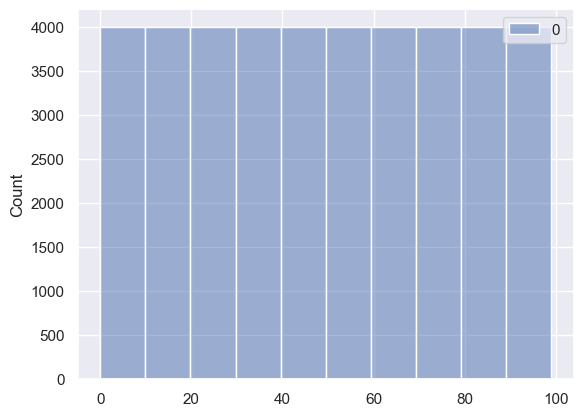

In [14]:
sns.histplot(y_train, bins=10)

We observe that there appears to be <strong>no sign</strong> of class imbalance for the fine labels. What about the coarse labels?

<AxesSubplot: ylabel='Count'>

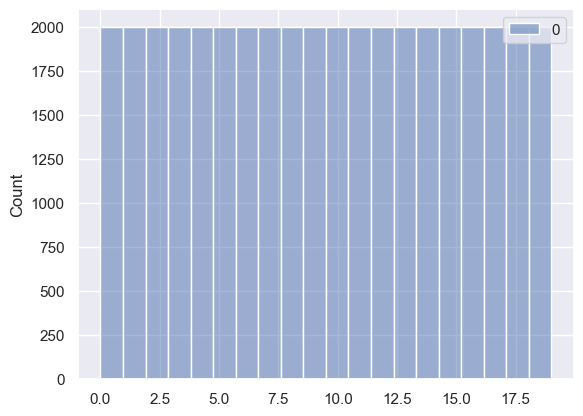

In [15]:
sns.histplot(y_train_coarse, bins=20)

It also appears that there are <strong>no signs of class imbalance</strong> for the coarse labels as well.

### Null values?
We perform a simple <code>.isnull()</code> check to see if there are any null values in any of our data

In [16]:
null_counts = 0
for iter_data in [X_train, y_train, X_val, y_val, X_test, y_test]:
	iter_data = pd.DataFrame(iter_data)
	null_counts += iter_data.isnull().sum().sum()

print("Null counts among ALL the data:", null_counts)

Null counts among ALL the data: 0


We observe that <strong>there are no null values</strong> in the dataset.

### What does the average image look like?
Let's take a look at a random sample of images.

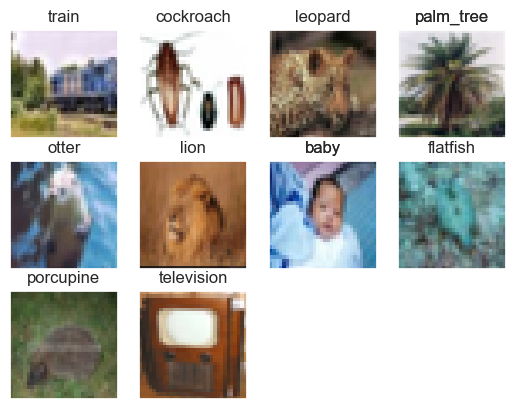

In [17]:
images = []
titles = []

for i in range(10):
	idx = random.sample(list(y_train[y_train == i].index), 1)
	images.append(X_train.loc[idx].values.reshape((3, 32, 32)))
	titles.append(classes[y_train.loc[idx].values[0][0]])

imshow(images, titles)

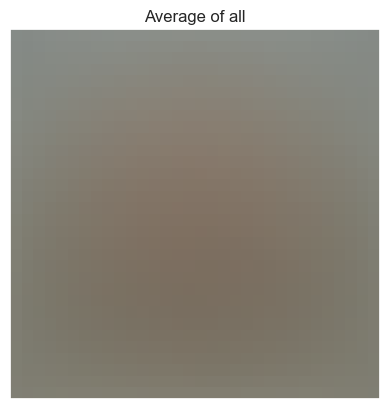

In [18]:
imshow([
	X_train.mean().apply(lambda x: x).values.reshape(3, 32, 32)
], ['Average of all'])

#### Average image among the classes
Next we'll split by the classes and find the average among them.

However, <strong>as our prediction will involve 100 outputs</strong>, what we'll do instead is use the <code>coarse classes</code>, which has 20 classes.

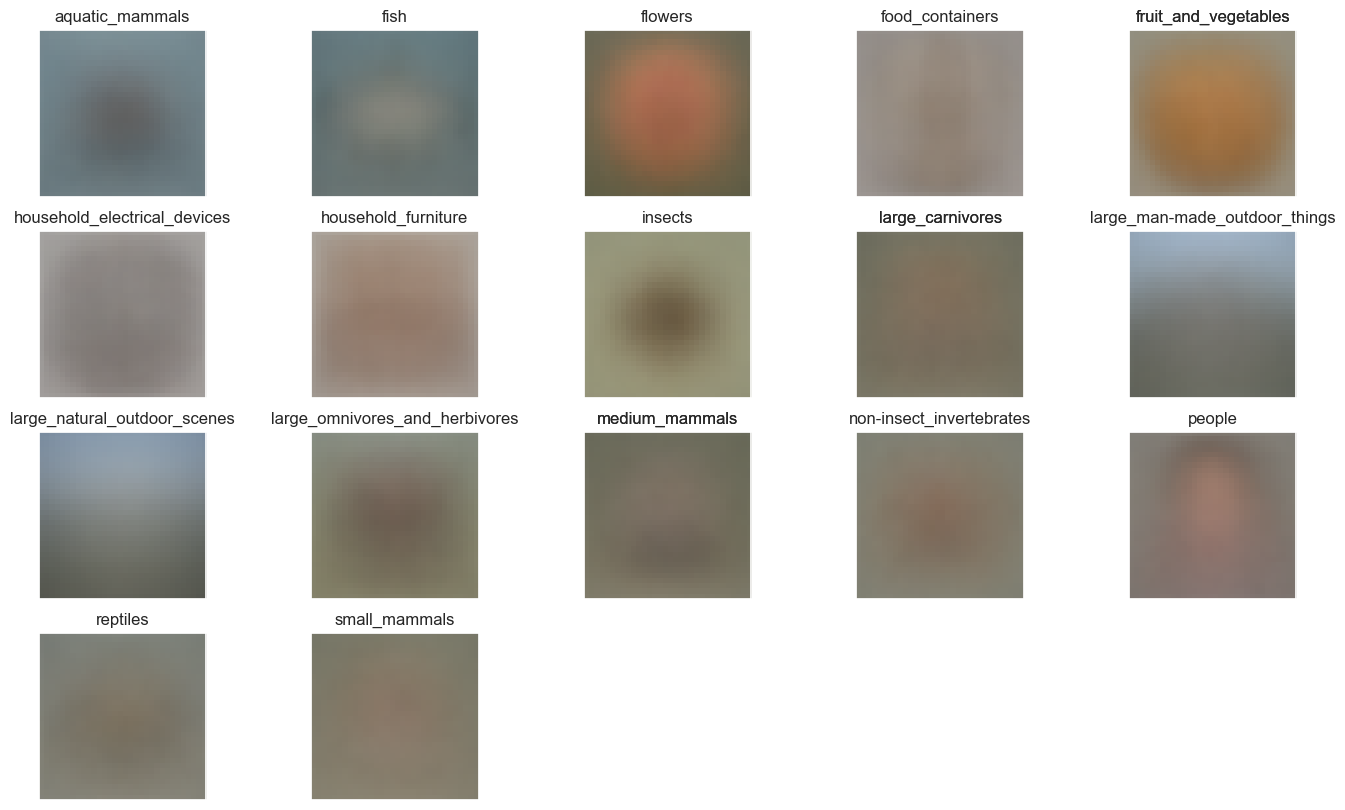

In [19]:
images = []
titles = []

for i in range(20):
	idx = np.where((y_train_coarse.values == i))[0].flatten()
	images.append(X_train.iloc[idx].values.reshape(-1, 3, 32, 32).mean(axis=0))
	titles.append(coarse_classes[i])

imshow(images, titles, figsize = (17, 10))

We observe:
<ul>
	<li>We can <strong>barely make out</strong> the figures for classes such as <code>insects</code>, <code>large_carnivore</code></li>
	<li>We observe a slight silhouette on the <code>people</code> image</li>
	<li>For most of the coarse classes, we can barely make out the shapes</li>
</ul>

Let's try to view the first <code>20 classes</code> from the fine classes.

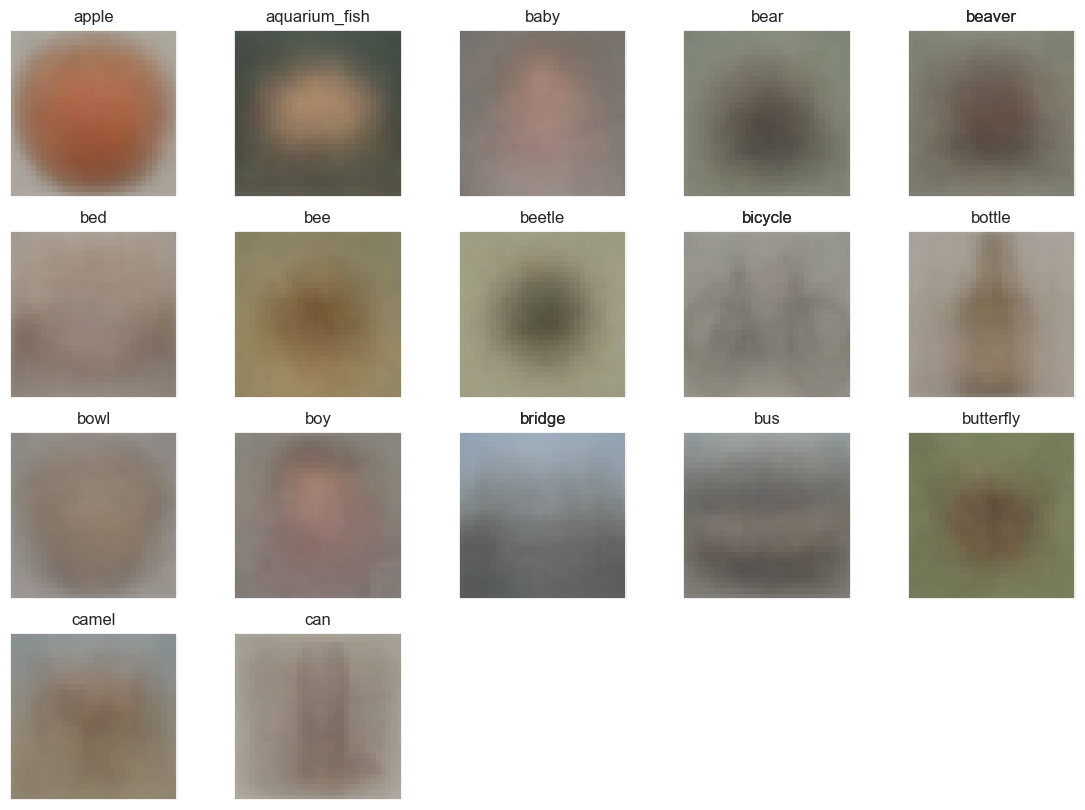

In [20]:
images = []
titles = []

for i in range(20):
	idx = np.where((y_train == i))[0].flatten()
	images.append(X_train.iloc[idx].values.reshape(-1, 3, 32, 32).mean(axis=0))
	titles.append(classes[i])

imshow(images, titles, figsize = (14, 10))

We observe:
<ol>
	<li>We see better resolution in the average images of <code>can</code> and <code>bottle</code> </li>
	<li>Interestingly, we can also recognize the bicycle in the image, alongside its wheels</li>
</ol>

### Are there any outliers/anomalies?
To determine such, one method we can do is to use a Convolution AutoEncoder to <strong>reconstruct</strong> the image. The i dea is that if we restrict the inner layers of the auto encoder, it will be forced to <strong>generalize among all the images</strong>. As such any outlier image will have a <strong>stark difference between the itself and the reconstructed image</strong>.

This "difference" between the images, will be calculated using the <strong>Mean Squared Error (MSE)</strong> between the two images. We use the <strong>squared</strong> to exaggerate the larger errors the autoencoder makes.

<strong>However</strong>, such Convolutioanl AutoEncoders work best for <strong>single-channel</strong> images. As the CIFAR-100 dataset is 3 channels, it is unlikely that Convolutional AutoEncoders will perform well. Additionally, autoencoders are not using information from the labels, which means this approach will tell us how far an image is from the <strong>'general' image</strong>, rather from the general image of it's class.

To tackle this, we'll instead use a ResNet feature extractor, training model to classify. From this, we'll remove the last few layers and use the rich <strong>feature embeddings</strong> in combination with an unsupervised learning method such as TSNE. Doing so, any data points that are <strong>far away from it's class cluster</strong>, suggests it will likely be an outlier.

We'll be using a modified and scaled down version of <strong>ResNet</strong>.

In [21]:
def relu_bn_conv(in_channels, out_channels, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip = False):
        super().__init__()
        self.skip = nn.Sequential()
        self.conv1 = relu_bn_conv(in_channels, out_channels, kernel_size = 3, padding = 1)

        if skip:
            self.conv1 = relu_bn_conv(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size= 1, stride = 2)

        self.conv2 = relu_bn_conv(out_channels, out_channels, kernel_size = 3, padding = 1)

    def forward(self, x):
        skip = self.skip(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + skip
        return nn.ReLU()(x)

class ResNetS(nn.Module):
    def __init__(self, base_filter = 16):
        super().__init__()

        in_channels = 3
        
        self.l0 = nn.Sequential(
            nn.Conv2d(in_channels, base_filter, kernel_size = 5, stride = 2, padding = 3),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(base_filter),
            nn.ReLU()
        )
        self.l1 = nn.Sequential(
            ResBlock(base_filter, base_filter, skip = False),
            ResBlock(base_filter, base_filter, skip = False),
        )
        self.l2 = nn.Sequential(
            ResBlock(base_filter, base_filter * 2, skip = True),
            ResBlock(base_filter * 2, base_filter * 2, skip = False),
        )
        self.l3 = nn.Sequential(
            ResBlock(base_filter * 2, base_filter * 3, skip = True),
            ResBlock(base_filter * 3, base_filter * 3, skip = False),
        )
        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Flatten(start_dim=1),
            torch.nn.Linear(base_filter * 3, 100)
        )

    def forward(self, x):
        x = self.l0(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.gap(x)
        x = self.fc(x)

        return x

#### Loading the dataset
Next we need to load the dataset. In order to do this, below is a custom class that acts as a wrapper <strong>to convert a pandas dataframe to PyTorch tensors</strong>, such that we are able to load the dataset into the <code>DataLoader</code> class.

In [22]:
def to_prob_dist(labels: torch.tensor, size = 100):
	arr = np.full((len(labels), size), 0)
	for i, label in enumerate(labels):
		arr[i][int(label.item())] = 1
	return torch.tensor(arr, dtype=torch.float32)

class TorchDataset(torch.utils.data.Dataset):
	def __init__(self, X, y, X_shape = (3, 32, 32), y_shape = (1, ), transform = None):
		if (type(X) == torch.Tensor):
			self.x = X
		else:
			self.x = df_to_tensor(X, X_shape)

		self.transform = transform
            
		if (type(y) == torch.Tensor):
			self.y = y
		else:
			self.y = df_to_tensor(y, y_shape)
			self.y = to_prob_dist(self.y)

		# Transform labels to probability distributions
	
	def __len__(self):
		return len(self.y)

	def __getitem__(self, idx):
		if torch.is_tensor(idx):
			idx = idx.tolist()

		selected = self.x[idx]
            
		if self.transform:
			selected = self.transform(selected)
        
		return selected, self.y[idx]

Now that we have defined our <code>TorchDataset</code>, we'll transform the <code>pd.DataFrame</code> to it to make it easy to use.

In [23]:
train_data = TorchDataset(X_train, y_train)
val_data = TorchDataset(X_val, y_val)

In [24]:
test_data = TorchDataset(X_test, y_test)

#### Training the Feature Extractor

Before we get started training, we <strong>prepare the training environment below.</strong>
This training environment will allow us to train, assess and visualize models with ease.

In [64]:
def accurate_count(pred, true):
	return ((pred.argmax(dim=1) == true.argmax(dim=1)).sum()).item()

def perform_augmentation(X_pass, y_pass, transform, n = 2, step = 4000):
	if n == 1:
		X = copy.deepcopy(X_pass)
		X = transform(X)
		final_y = copy.deepcopy(y_pass)
	else:
		X = copy.deepcopy(X_pass)
		y = copy.deepcopy(y_pass)
		final_y = copy.deepcopy(y_pass)
		original_len = len(X)
		for i in range(n - 1):
			transformed_arr = transform(X[:step])
			for j in range(step, original_len, step):
				print('j:',j)
				transformed = transform(X[j:j+step])
				transformed_arr = torch.cat((transformed_arr, transformed), dim = 0)        
			X = torch.cat((X, transformed_arr), dim = 0)
			final_y = torch.cat([final_y, y])
	return X, final_y

class Logger():
	def __init__(self, path = 'plots/log.txt'):
		self.path = path
	
	def log(self, msg):
		file = open(self.path, 'a')
		file.write(str(msg) + '\n')
		file.close()

!pip install tqdm
from tqdm import tqdm
	
class Trainer():
	def __init__(self):
		self.saves = {}
		self.loss_tracker = {}
		self.history = pd.DataFrame()

	def show_history(self):
		pass

	def train_model(self, name, model_pass, optimizer_pass, optimizer_args,
					train_data: TorchDataset, model_args = {}, scheduler_pass = None,
					scheduler_args = None, batch_size = GPU_COUNT * 256,
					early_stopping = None, epochs = 200, verbose = False,
					val_data = val_data, save_model = False, augment = None,
					return_model = False):

		logger = Logger()

		logger.log(model_pass)

		model = model_pass(**model_args)
		model = model.to(device)
		model = nn.DataParallel(model)

		optimizer = optimizer_pass(model.parameters(), **optimizer_args)
		criterion = nn.CrossEntropyLoss()
		train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 0 if WINDOWS else min(12, 4 * GPU_COUNT))
		val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True, num_workers = 0 if WINDOWS else min(12, 4 * GPU_COUNT))

		if scheduler_pass != None:
			scheduler = scheduler_pass(optimizer, **scheduler_args)

		done = 0
		n_epochs = epochs

		track_loss = np.full((epochs, 4), 0.0, dtype=np.float32) # train acc, train loss, val acc, val loss

		best_performance_df = pd.DataFrame({'Train Loss': 1000, 'Val Loss': 1000, 'Train Acc': 0, 'Val Acc': 0}, index = [name])
		best_val_loss = 1e9
		best_val_acc = 0

		self.end_training = 0
		self.extra_trained = 0

		for epoch in range(1, n_epochs+1):
			# monitor training loss
			train_loss = 0.0
			train_acc_count = 0
			total_sample = 0
			
			###################
			# train the model #
			###################
			model.train()
			for data in tqdm(train_loader):
				# _ stands in for labels, here
				# no need to flatten images
				inputs, labels = data
				inputs = inputs.cuda()
				labels = labels.cuda()

				perform_aug = np.random.random() < 0.4 
				if augment != None and perform_aug:
					batch, perm, lmbd = augment['fn'](inputs.detach().cpu(), *augment['args'], **augment['kwargs'])

					inputs = batch.cuda()
					outputs = model(inputs)

					loss = criterion(outputs, labels) * lmbd + criterion(outputs, labels[perm]) * (1 - lmbd)
				else:
					# forward pass: compute predicted outputs by passing inputs to the model
					outputs = model(inputs)
					# calculate the loss
					loss = criterion(outputs, labels)
					# backward pass: compute gradient of the loss with respect to model parameters
					train_loss += loss.item()
					train_acc_count += accurate_count(outputs, labels)
					total_sample += len(labels)

				optimizer.zero_grad()
				loss.backward()
				optimizer.step()
				
				if scheduler_pass != None:
					scheduler.step()
					
			train_loss = train_loss/len(train_loader)
			train_acc = train_acc_count / total_sample

			val_loss = 0.0
			val_acc_count = 0
			total_sample = 0
			
			model.eval()
			with torch.no_grad():
				for i, data in enumerate(val_loader):
					inputs, labels = data                             
					inputs = inputs.to(device)
					labels = labels.to(device)

					outputs = model(inputs)
					loss = criterion(outputs, labels)

					val_loss += loss.item()
					val_acc_count += accurate_count(outputs, labels)
					total_sample += len(labels)

			val_loss = val_loss / len(val_loader)
			val_acc = val_acc_count / total_sample

			if verbose:
				print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} \tVal Loss: {val_loss:.5f} \tTrain Acc: {train_acc:.3f} \tVal Acc: {val_acc:.3f}")
			logger.log(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} \tVal Loss: {val_loss:.5f} \tTrain Acc: {train_acc:.3f} \tVal Acc: {val_acc:.3f}")

			track_loss[epoch - 1][0] = train_acc
			track_loss[epoch - 1][1] = train_loss
			track_loss[epoch - 1][2] = val_acc
			track_loss[epoch - 1][3] = val_loss
			done = epoch

			if val_loss < best_val_loss:
				best_performance_df = pd.DataFrame({'Train Loss': train_loss, 'Val Loss': val_loss, 'Train Acc': train_acc, 'Val Acc': val_acc}, index = [name])
				self.end_training = epoch
				best_val_loss = val_loss
				best_val_acc = max(best_val_acc, val_acc)
				if save_model:
					self.save_model(name, model)
			elif val_acc > best_val_acc:
				best_performance_df = pd.DataFrame({'Train Loss': train_loss, 'Val Loss': val_loss, 'Train Acc': train_acc, 'Val Acc': val_acc}, index = [name])
				self.end_training = epoch
				best_val_acc = val_acc
				best_val_loss = min(best_val_loss, val_loss)
				if save_model:
					self.save_model(name, model)

			if early_stopping != None:
				early_stopping(val_loss, val_acc)

			if early_stopping != None and early_stopping.stop:
				if (verbose):
					print(f"Stopping due to early stopping | patience = {early_stopping.patience}")
				logger.log(model_pass)
				break


		track_loss.resize((done, 4))
		self.record(name, track_loss, best_performance_df)

		if return_model:
			del train_loader, val_loader, inputs, labels
			torch.cuda.empty_cache()
			return model
		else:
			del model, optimizer, train_loader, val_loader, inputs, labels
			torch.cuda.empty_cache()

	def record(self, name, track_loss, best_performance_df):
		track_loss_df = pd.DataFrame(track_loss, columns=['Train Acc', 'Train Loss', 'Val Acc', 'Val Loss'])
		track_loss_df.index += 1
		track_loss_df.index.name = 'Epoch'

		try:
			self.history = pd.read_csv('plots/record.csv')
		except:
			self.history = pd.DataFrame()

		self.history = pd.concat([self.history, best_performance_df], axis=0)
		self.history.to_csv('plots/record.csv')
		self.loss_tracker[name] = track_loss_df

	def save_model(self, name, model):
		self.saves[name] = copy.deepcopy(model)

	def get_model(self, name):
		return copy.deepcopy(self.saves[name])

	def archive(self, name):
		fig = plt.figure(figsize=(14, 5))
		train, val = sns.color_palette('Set2')[0:2]
		loss, acc = fig.subplots(1, 2)

		loss.axvspan(1, self.end_training, color=sns.color_palette('Paired')[0], alpha=0.4, lw=0, label='Training') 

		loss.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Train Loss'], label='Train', color=train)
		loss.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Val Loss'], label='Val', color=val)
		loss.set_xlabel('Epoch')
		loss.set_ylabel('Loss')

		acc.axvspan(1, self.end_training, color=sns.color_palette('Paired')[0], alpha=0.4, lw=0, label='Training') 
		acc.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Train Acc'], label='Train', color=train)
		acc.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Val Acc'], label='Val', color=val)

		acc.set_xlabel('Epoch')
		acc.set_ylabel('Accuracy')

		acc.legend()
		loss.legend()
		
		fig.savefig(f'plots/{name}.png')
		plt.close()
		del self.loss_tracker[name]

We'll train our feature extractor for 50 epochs.

In [26]:
if not DEBUG:
	trainer = Trainer(nn.CrossEntropyLoss)
	res_model = trainer.train_model(
		'ResNet-S Feature Extractor', ResNetS, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		epochs = 50,
		# verbose=True,
		return_model = True
	)
	trainer.archive('ResNet-S Feature Extractor')
	display(trainer.history)

Now that we have a trained a simple and small ResNet feature extractor, we can <strong>use its feature mapping</strong>. We cut off the last layers of the model below.

In [27]:
if not DEBUG:
	feature_extractor = torch.nn.Sequential(*(list(list(res_model.children())[0].children())[:-2]))

We then load our data into a dataloader. This is because giving all the images to the model at once for inference will lead to <strong>insufficient memory</strong>. We'll also store information into a <code>pd.DataFrame</code> such that we can pass this information to <strong><code>TSNE</code> to perform manifold learning</strong>.

<strong>Why <code>TSNE</code>?</strong>  

I decided to use TSNE because it allows for non-linear relationships where as a dimensionality reduction technique such as <code>PCA</code> only performs well for linear relationships inside the data.

In [28]:
if not DEBUG:
	output = pd.DataFrame()
	batch_size = 100
	train_loader = DataLoader(train_data, batch_size = batch_size)
	for data in train_loader:
		image, label = data
		output = pd.concat([output, pd.DataFrame(feature_extractor(image).detach().cpu().numpy().reshape(batch_size, -1))], axis=0)

Below we use <code>MulticoreTSNE</code>, which is a <strong>faster implementation</strong> of Sklearn's <code>TSNE</code>, despite Sklearn also implementing multicore support with <code>n_jobs</code>. We also <strong>set the number of components to be 4</strong>, as not only does the dataset have a lot of classes, but contains a lot of information.

In [29]:
if not DEBUG:
	from MulticoreTSNE import MulticoreTSNE as TSNE
	tsne = TSNE(n_components = 4, method='exact', n_jobs=-1)
	results = tsne.fit_transform(output)

Next, we need to calculate how far each image is from the 'mean' of its images.

In [30]:
if not DEBUG:
	y_train.columns = ['label']
	tsne_df = pd.concat([pd.DataFrame(results), y_train], axis=1)
	tsne_means = tsne_df.groupby(by='label').mean()
	tsne_means.columns = ['mean_0', 'mean_1', 'mean_2', 'mean_3']
	distance_tsne = tsne_df.join(tsne_means, on='label')
	distance_tsne['dist_from_mean'] = ((distance_tsne[[0, 1, 2, 3]].values - distance_tsne[['mean_0', 'mean_1', 'mean_2', 'mean_3']].values) ** 2).sum(axis=1)

After calculating the distance, we'll now inspect what <strong>our "Outlier Detection" method</strong> reveals about the dataset.

In [31]:
if not DEBUG:
	farthest_idx = distance_tsne.sort_values(by='dist_from_mean', ascending = False).iloc[0:16].index
	closest_idx = distance_tsne.sort_values(by='dist_from_mean', ascending = True).iloc[0:16].index

We'll first <strong>inspect images</strong> that the algorithm considers to be <strong>far way</strong> from its respective class.

In [32]:
if not DEBUG:
	imshow(train_data.x[farthest_idx].cpu().numpy(), classes[np.argmax(train_data.y[farthest_idx].cpu().numpy(), axis=1)].tolist(), figsize=(7, 7))

We observe:
<ul>
	<li>The first thing we see is that <code>orchid</code> and <code>sunflower</code> are blue, indicating <strong>outliers in the form of colors</strong></li>
	<li>This suggests that the color channels for these two particular images and incorrect, and implies that performing <strong>color altering augmentation</strong> is likely going to benefit our model performance</li>
	<li>We also observe there to be quite a few <code>dolphins</code>, <code>shark</code>, and <code>whale</code>.</li>
	<li>This may be due to our model's feature maps being incorrect, for instance assigning said dolphin a feature map of a shark, resulting to a large distance away from the dolphin's mean vectors.</li>
</ul>

It is likely that using a better performing feature extractor will lead to better results, as it seems the modified ResNet-S does not have the model capacity to be able to distinguish between closely related classes.

Next, we'll analyse the <strong>closest images</strong> to the mean.

In [33]:
if not DEBUG:
	imshow(train_data.x[closest_idx].cpu().numpy(), classes[np.argmax(train_data.y[closest_idx].cpu().numpy(), axis=1)].tolist(), figsize=(7, 7))

We observe:
<ul>
	<li>Most of the images are <code>plain</code> and <code>sea</code>, which tells us the model was easily able to extract features effectively</li>
	<li>This is highly likely due to the fact that the <code>separation between the sky and the earth</code>, results to <strong>easy identification</strong></li>
	<li>Trees appear to also be easily identifiable.</li>
</ul>

#### What about coarse classes?

As our model is still not quite robust, such as giving similar feature maps to dolphins and sharks, perhaps more <strong>coarse labels</strong> will result in better identification of outliers.

### Would <strong>rotational data augmentation</strong> be of use?
Convolutional Neural Networks are proven to have the property of <strong>translation invariance</strong> and <strong>translation equivariance</strong>, which means regardless of the translations performed on the image, the feature map of the CNN will be also translated. Essentially,

$$c(t(x)) = t(c(x))$$

Where $t$ represents translation and $c$ represents the convolutional network.

However, CNN do not have any invariance to rotational. Would performing rotational data augmentation be of use? To find this out, <strong>I designed a custom algorithm</strong> to detect whether there exists rotated images. We'll specifically be using the algorithm on the class of <code>cans</code> because it is easier to detect for rotated images (as cans are usually upright).

The idea is this:
<ol>
	<li>Apply <strong>vertical convlutional layer</strong> to the original image, to <strong>extract vertical lines</strong></li>
	<li>Apply <strong>horizontal convlutional layer</strong> to the original image, to <strong>extract horizontal lines</strong></li>
	<li>Then from these outputs of the 2 convolutional layers, we want to find out what the <strong>"longest line"</strong> is</li>
	<li>If the vertical output has a longer line than the horizontal output, the image is likely to be upright, and vice versa</li>
</ol>

We define the <strong>horizontal and vertical convolution weights</strong> below.

In [34]:
vert_weights = torch.Tensor(
    [[1, 0, -1], [1, 0, -1], [1, 0, -1]]
).unsqueeze(0).unsqueeze(0)
vert_weights.requires_grad = True

vert_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)

with torch.no_grad():
    vert_conv.weight = nn.Parameter(vert_weights)

vert_conv = vert_conv.cuda()

hori_weights = torch.Tensor(
    [[1, 1, 1], [0, 0, 0], [-1, -1, -1]]
).unsqueeze(0).unsqueeze(0)
hori_weights.requires_grad = True

hori_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)

with torch.no_grad():
    hori_conv.weight = nn.Parameter(hori_weights)

hori_conv = hori_conv
hori_layer = nn.Sequential(
    hori_conv,
    nn.BatchNorm2d(1)
).cuda()

Next, we restrict the space of images to only those that have the <code>can</code> label.

In [35]:
idx = np.where(y_train == 16)[0]
cans_x = train_data.x[idx]

As an example, let's interpret what the two <strong>vertical and horizontal convolutional filters</strong> are doing.

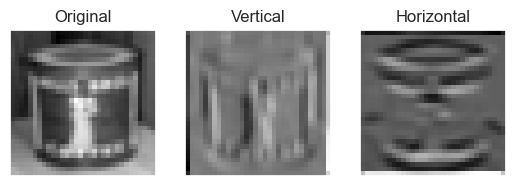

In [36]:
gray_cans = transforms.functional.rgb_to_grayscale(cans_x, 1)

gray_can_example = gray_cans[0]
hori = hori_conv(gray_can_example.cuda())
vert = vert_conv(gray_can_example.cuda())

imshow([gray_can_example, vert, hori], label=['Original', 'Vertical', 'Horizontal'], is_int = False)

We see that because the <strong>vertical output has "longer" lines</strong>, this means the image is <strong>likely to be upright</strong>, which is the case.

Thus, we'll continue to <strong>define</strong> our algorithm in a function, <strong>apply</strong> the function to all the <code>can</code> images in the training dataset, and then <strong>visualize</strong> them to perform a check on rotated images.

In [37]:
horizontal_images = []

def color_diff_lengths(image, orientation = 'hori'):
		if len(image.shape) == 3:
			image = image.reshape(32, 32)

		if orientation == 'hori':
			image = image[1:-1, :]
			means = image.mean(axis=1)
			left = np.argmax(np.apply_along_axis(lambda x: x <= means, 0, image), axis=1)
			right = (image.shape[1] - 1) - np.argmax(np.apply_along_axis(lambda x: x >= means, 0, image[:, ::-1]), axis=1)
		else:
			image = image[:, 1:-1]
			means = image.mean(axis=0)
			left = np.argmax(np.apply_along_axis(lambda x: x <= means, 1, image), axis=0)
			right = (image.shape[0] - 1) - np.argmax(np.apply_along_axis(lambda x: x >= means, 1, image[::-1, :]), axis=0)

		return max(right - left)

for img in gray_cans:
	vertical_length = color_diff_lengths(vert_conv(img.cuda()).detach().cpu().numpy().transpose(1, 2, 0), orientation = 'vert')
	horizontal_length = color_diff_lengths(hori_conv(img.cuda()).detach().cpu().numpy().transpose(1, 2, 0), orientation = 'hori')

	if horizontal_length > vertical_length:
		horizontal_images.append(img.cpu().numpy())

Let's take a look at the images

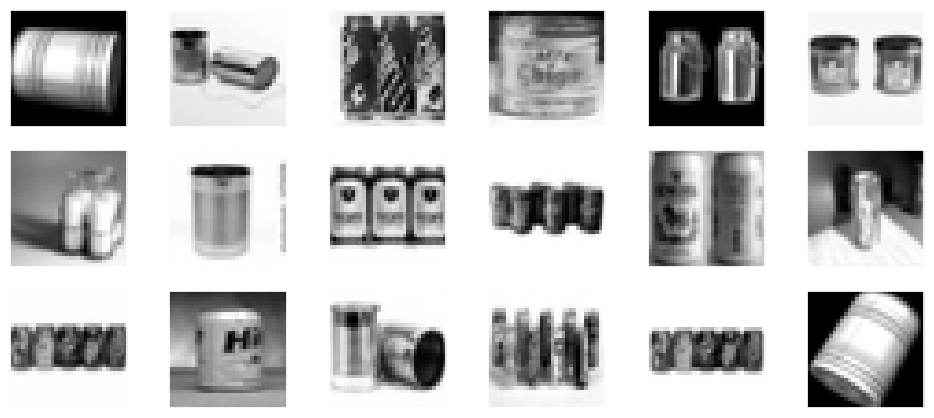

In [38]:
imshow(horizontal_images, shape=(32, 32), figsize = (12, 7))

We observe:
<ul>
	<li>Our algorithm is not completely robust, <strong>there are instances of upright cans</strong></li>
	<li>However, there are also <strong>many upright cans</strong>, stacked in a horizontal manner</strong>, leading to our algorithm believing that they are horizontal</li>
	<li>There are a few images of a combination of horizontal cans and vertical cans, with one image of a horizontal can</li>
</ul>

As this can likely extend to other classes (maybe even more likely, e.g. dolphin swimming up and dolphin swimming towards the right), we conclude that <strong>rotational augmentation</strong> will definitely help with our model.

## Feature Engineering
Before we proceed with anything else, we'll first <strong>normalize</strong> the data. This means we'll divide every value in the dataset by <code>255</code>.

In [39]:
train_data.x /= 255.0
val_data.x /= 255.0

## Data Augmentation
For data augmentation we <strong>note from EDA that:</strong>
<ul>
	<li>Rotational augmentation are likely to be useful (at least for <code>cans</code>)</strong>
	<li>Color augmentations are also useful</strong>
</ul>

As such we'll with performing an <strong>augmentation algorithm</strong> called <strong>AutoAugment</strong>

In [40]:
t_auto = transforms.Compose([
	transforms.Lambda(lambda x: x.type(torch.uint8) if (x > 1).sum() > 0 else (x * 255).type(torch.uint8)),
	transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
	transforms.Lambda(lambda x: x.float() / 255.0),
])

t_dtype = transforms.Lambda(lambda x: x.float() / 255.0 if (x > 1).sum() > 0 else x)

t_extra_auto = transforms.Compose([
	t_auto,
	t_dtype,
	transforms.RandomCrop(32, padding=3),
	transforms.RandomHorizontalFlip(p=0.5),
	transforms.RandomRotation((-60, 60))
])

t_base = transforms.Compose([
	t_dtype,
	transforms.RandomCrop(32, padding=3),
	transforms.RandomHorizontalFlip(p=0.5),
])

# t_augmix = transforms.Compose([
# 	transforms.Lambda(lambda x: x.type(torch.uint8) if (x > 1).sum() > 0 else (x * 255).type(torch.uint8)),
# 	transforms.AugMix(severity=8, mixture_width = 5),
# 	transforms.Lambda(lambda x: x.float() / 255.0),
# ])

# t_extra_augmix = transforms.Compose([
# 	t_augmix,
# 	t_dtype,
# 	t_flip
# ])

# Normalize training set together with augmentation

j: 1
j: 2
j: 3
j: 4


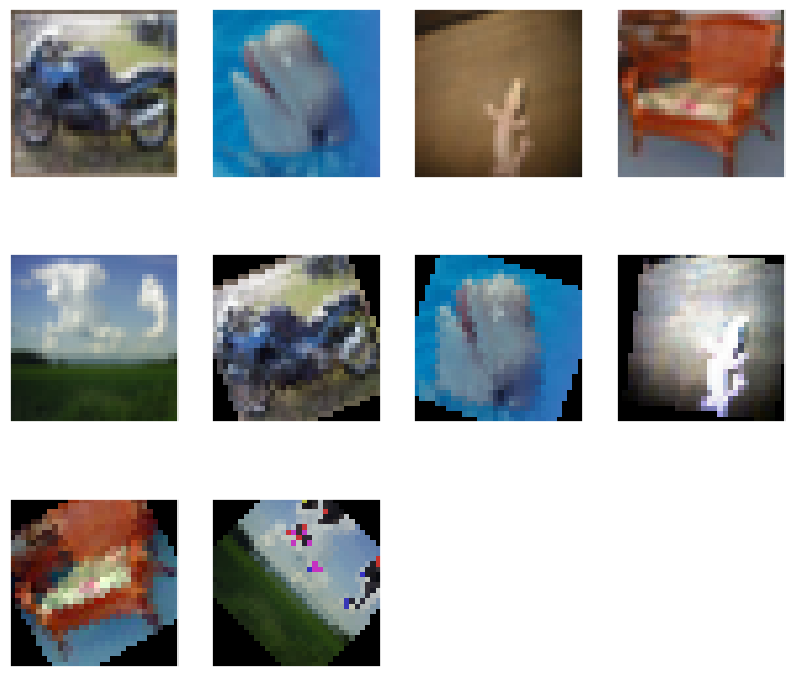

In [41]:
aug_X, aug_y = perform_augmentation(train_data.x[0:5], train_data.y[0:5], t_extra_auto, step = 1)
imshow(aug_X, figsize = (10, 9))

In [42]:
base_train_data = TorchDataset(X_train, y_train, transform = t_base)
auto_train_data = TorchDataset(X_train, y_train, transform = t_extra_auto)

## Modelling

### Metric
We'll be using two metrics: <strong>Accuracy</strong> and <strong>Categorical Crossentropy</strong>

$$accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$

$$\text{categorical crossentropy} = -\sum_{i=1}^{n}y_i \log{(p_i)} $$

We use accuracy to choose the model, as the benchmarks for the CIFAR100 dataset are in terms of accuracy. Additionally, the dataset does not have an imbalanced class issue, thus using accuracy is not unsuitable.

We use categorical crossentropy as our criterion to train the model, because it heavily penalizes models that are confident and wrong in their prediction. This is due to the logarithmic function in the cross entropy formula. 

#### Custom Early Stopping
Additionally, instead of <strong>arbitrarily choosing the number of epochs</strong> or fine tuning it (which computationally will take long), I decided to use <strong>Early Stopping</strong> as a mechanism.

Overfitting is something that occurs when a model begins to extract some of the residual variation such as noise under the assumption that it is learning the patterns (Burnham and Anderson, 2010). Essentially, it starts to <strong>memorize instead of generalize</strong>. Traditional Early Stopping attempts to combat overfitting by stopping training if the performance/loss of the model on a validation set does not improve over $n$ epochs, where $n$ is the patience parameter. However, it requires <strong>clever tuning</strong> to prevent underfitting (Adam, 2018). As such to address this problem, I use a custom implemented early stopping class inspired by this <a href="https://alexadam.ca/2018/08/03/early-stopping/">article</a>.

The idea of this custom early stopping is that we <strong>only stop training</strong> if there are no improvements in <strong>both loss and accuracy</strong>. If there is an improve in any of the single quantities, the patience counter is reset. This tackles the issue of the underlying assumption that <strong>"loss is correlated with accuracy</strong>", and becomes a more lenient form of early stopping, ideally decreasing underfitting.

In [43]:
class CustomEarlyStopping():
	def __init__(self, patience, min_loss_delta = 0, min_acc_delta = 0):
		self.patience = patience
		self.best_loss = 1e9
		self.best_acc = 0
		self.patience_count = 0
		self.count = 0
		self.stop = False

		self.min_loss_delta = min_loss_delta
		self.min_acc_delta = min_acc_delta

	def __call__(self, loss, accuracy):
		self.save_state = False

		if self.best_loss - loss > self.min_loss_delta or accuracy - self.best_acc > self.min_acc_delta:
			if self.best_loss - loss > self.min_loss_delta:
				self.best_loss = loss
			if accuracy - self.best_acc > self.min_acc_delta:
				self.best_acc = accuracy

			self.count = 0
		else:
			self.count += 1
		
		if self.count >= self.patience:
			self.stop = True


In [44]:
trainer = Trainer()

### Model Architectures

In this assignment, we are to investigate both the datasets for <strong>fine</strong> and <strong>coarse</strong> labels. Although the intuition is that <strong>any model that performs well on fine labels, will perform on the coarse labels</strong> (due to the differences being quite literally one more dense layer), it is important to really investigate and check if this is true. We'll tackle this later.

For now, let's first attempt to find appropriate model architectures to solve the problem of <strong>fine labels(100 classes)</strong>.

#### Baseline NN

As a reference point, we'll see how a baseline neural network consisting of only neurons will perform.

It consists of:
<ol>
	<li>Linear layer</li>
	<li>Batch Normalization</li>
	<li>ReLU activation function</li>
</ol>

In [45]:
def fc_block(in_feat, out_feat):
	return nn.Sequential(
		nn.Linear(in_feat, out_feat),
		nn.BatchNorm1d(out_feat),
		nn.ReLU()
	)

class BaselineNN(nn.Module):
	def __init__(self):
		super(BaselineNN, self).__init__()
		self.flat = nn.Flatten(1)
		self.b1 = fc_block(3072, 1536)
		self.b2 = fc_block(1536, 768)
		self.b3 = fc_block(768, 384)
		self.b4 = fc_block(384, 192)
		self.b5 = fc_block(192, 100)

	def forward(self, x):
		x = self.flat(x)
		x = self.b1(x)
		x = self.b2(x)
		x = self.b3(x)
		x = self.b4(x)
		x = self.b5(x)
		return x

In [46]:
trainer = Trainer()
batch_num = len(DataLoader(auto_train_data, batch_size = GPU_COUNT * 256))

if not MODEL_DEBUG:
	trainer.train_model(
		'AutoAugment + Baseline NN', BaselineNN, # model
		optim.AdamW, {'lr': 1e-4 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		auto_train_data, # data
		early_stopping = CustomEarlyStopping(patience = 7),
		verbose=True
	)
	trainer.archive('AutoAugment + Baseline NN')
	display(trainer.history)

#### AlexNet-inspired CNN: MiniAlexNet

In [47]:
class MiniAlexNet(nn.Module):
	def __init__(self, num_classes = 100):
		super(MiniAlexNet, self).__init__()

		self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
		)

		self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, stride=2, padding=2),
            nn.ReLU(),
		)

		self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
		)

		self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
			nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
		)

		self.avgpool = nn.AdaptiveAvgPool2d((2, 2))

		self.fc = nn.Sequential(
			nn.Dropout(p = 0.5),
			nn.Linear(256 * 2  * 2, 1024),
			nn.ReLU(),
			nn.Dropout(p = 0.5),
			nn.Linear(1024, 1024),
			nn.ReLU(),
			nn.Linear(1024, num_classes)
		)

	def forward(self, x):
		x = self.conv1(x)
		x = self.conv2(x)
		x = self.conv3(x)
		x = self.conv4(x)
		x = self.avgpool(x)
		x = torch.flatten(x, 1)
		x = self.fc(x)
		return x

In [48]:
if not MODEL_DEBUG:
	trainer.train_model(
		'AutoAugment + MiniAlexNet', MiniAlexNet, # model
		optim.AdamW, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		auto_train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True
	)
	trainer.archive('AutoAugment + MiniAlexNet')
	display(trainer.history)

#### Modified VGG15
From our past experiment, VGG15 worked incredibly well.

In [49]:
def VGGBlock(in_channels, out_channels, pool = False, activation = nn.ReLU):
	if pool:
		return nn.Sequential(
			nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
			nn.BatchNorm2d(out_channels),
			activation(),
			nn.MaxPool2d(kernel_size = 2, stride = 2)
		)
	return nn.Sequential(
		nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
		nn.BatchNorm2d(out_channels),
		activation()
	)

class VGG15(nn.Module):
	def __init__(self, num_classes = 100):
		super().__init__()
		self.l0 = VGGBlock(3, 64)
		self.l1 = VGGBlock(64, 64)
		self.l2 = VGGBlock(64, 64, pool = True)
		self.l3 = VGGBlock(64, 128)
		self.l4 = VGGBlock(128, 128)
		self.l5 = VGGBlock(128, 128, pool = True)
		self.l6 = VGGBlock(128, 256)
		self.l7 = VGGBlock(256, 256)
		self.l8 = VGGBlock(256, 256, pool = True)
		self.l9 = VGGBlock(256, 512)
		self.l10 = VGGBlock(512, 512)
		self.l11 = VGGBlock(512, 512, pool = True)
        
		self.flat = nn.Flatten(start_dim = 1)
		self.drop_layer0 = nn.Dropout(0.5)
		self.fc0 = nn.Sequential(
			nn.Linear(512 * 2 * 2, 4096),
			nn.ReLU()
		)
        
		self.drop_layer1 = nn.Dropout(0.5)    
		self.fc1 = nn.Sequential(
			nn.Linear(4096, 4096),
			nn.ReLU()
		)
        
		self.fc2 = nn.Sequential(
			nn.Linear(4096, num_classes)
		)


	def forward(self, x):
		x = self.l0(x)
		x = self.l1(x)
		x = self.l2(x)
		x = self.l3(x)
		x = self.l4(x)
		x = self.l5(x)
		x = self.l6(x)
		x = self.l7(x)
		x = self.l8(x)
		x = self.l9(x)
		x = self.l10(x)
		x = self.l11(x)
		x = self.flat(x)
		x = self.drop_layer0(x)
		x = self.fc0(x)
		x = self.drop_layer1(x)
		x = self.fc1(x)
		x = self.fc2(x)
		return x
    
	def __repr__(self):
		return "VGG15"

In [50]:
if not MODEL_DEBUG:
	trainer = Trainer()
	trainer.train_model(
		'AutoAugment + VGG15', VGG15, # model
		optim.AdamW, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		base_train_data, # data
		# scheduler_pass = torch.optim.lr_scheduler.StepLR,
		# scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.97},
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True
	)
	trainer.archive('AutoAugment + VGG15')
	display(trainer.history)

As we generally see that augmentation helps with improving the performance of the models, we'll apply augmentation on all the different models.

#### AutoAugment + ResNet50

The next model we try is ResNet50. The issue with VGG is that it suffers from the <strong>vanishing gradient</strong> problem. Although sometimes it may not have an effect on the performance (such as seen with the FashionMNIST dataset), we'll.

As ResNet has 'skip' blocks, essentially countering the <strong>vanishing gradient</strong> issue, it means we can have a deeper network that does not suffer from the problem.

In [51]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 2
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet50(nn.Module):

    def __init__(self, block = BottleNeck, num_block = [3, 4, 6, 3], num_classes=100):
        super().__init__()
        block = BottleNeck
        num_block = [3, 4, 6, 3]

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = self.dropout(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output


In [52]:
if not MODEL_DEBUG:
	trainer.train_model(
		'AutoAugment + ResNet50', ResNet50, # model
		optim.AdamW, {'lr': 1e-3 * (GPU_COUNT ** 0.5), 'weight_decay': 1e-5}, # optimizer
		auto_train_data, # data
		scheduler_pass = torch.optim.lr_scheduler.StepLR,
		scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.97},
		early_stopping = CustomEarlyStopping(patience = 10),
		verbose=True
	)
	trainer.archive('AutoAugment + ResNet50')
	display(trainer.history)

#### EfficientNet V2-M
ResNets are inefficient. EfficientNet uses an MBConv block, inspired by the residual block. This architecture is not only efficient but performs better than traditional previously novel convolutional neural networks.

In [53]:
# Code adapted from https://github.com/d-li14/efficientnetv2.pytorch/blob/main/effnetv2.py

import torch
import torch.nn as nn
import math

def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


# SiLU (Swish) activation function
if hasattr(nn, 'SiLU'):
    SiLU = nn.SiLU
else:
    # For compatibility with old PyTorch versions
    class SiLU(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)

 
class SELayer(nn.Module):
    def __init__(self, inp, oup, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(oup, _make_divisible(inp // reduction, 8)),
                SiLU(),
                nn.Linear(_make_divisible(inp // reduction, 8), oup),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        SiLU()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        SiLU()
    )


class MBConv(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_se):
        super(MBConv, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup
        if use_se:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SiLU(),
                SELayer(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # fused
                nn.Conv2d(inp, hidden_dim, 3, stride, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class EffNetV2(nn.Module):
    def __init__(self, num_classes=100, width_mult=1.):
        super(EffNetV2, self).__init__()
        cfgs = [
            # t, c, n, s, SE
            [1,  24,  2, 1, 0],
            [4,  48,  4, 2, 0],
            [4,  64,  4, 2, 0],
            [4, 128,  6, 2, 1],
            [6, 160,  9, 1, 1],
            [6, 256, 15, 2, 1],
        ]
        self.cfgs = cfgs

        # building first layer
        input_channel = _make_divisible(24 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = MBConv
        for t, c, n, s, use_se in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t, use_se))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        output_channel = _make_divisible(1792 * width_mult, 8) if width_mult > 1.0 else 1792
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(output_channel, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.001)
                m.bias.data.zero_()

In [54]:
if not MODEL_DEBUG:
	from torchvision.models import efficientnet_b0
	trainer.train_model(
		'AutoAugment + EfficientNet B0', efficientnet_b0, # model
		optim.AdamW, {'lr': 1e-3 * (GPU_COUNT ** 0.5), 'weight_decay': 1e-5}, # optimizer
		auto_train_data, # data
		model_args = {'num_classes': 100}, 
		scheduler_pass = torch.optim.lr_scheduler.StepLR,
		scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.97},
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True
	)
	trainer.archive('AutoAugment + EfficientNet B0')
	display(trainer.history)


#### AutoAugment + Convolutional Vision Transformers
Vision Transformers have taken over SOTA results, beating previous benchmarks. However, there is a key problem with traditional ViT, in that <strong>the token embedding layer from the image to embedding vectors is linear.</strong> To account for positional information, ViT <strong>adds on positional encodings</strong> to the linear embeddings, before passing it on to projection and then to the Multi-Head Self Attention (MHSA) mechanism. (Dosovitskiy et al., 2020)

Convolutional Vision Transformers (CvT) proposes to <strong>use a convolutional layer for this embedding area, and uses depthwise separable convolutions for the projection layer.</strong> We note that the convolutional layer for embedding layer and projection layers <strong>are different</strong>. (Wu et al., 2021)

The addition of convolution into the Transformer architecture allows for the benefits of convolution (shift, scale and distortion invariance) to be incorporated into every feature map (output from Convolution Transformer Blocks), and also controls for the sizes of feature maps after each blocks output. (Wu et al., 2021)

In [55]:
class SepConv2d(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,):
        super(SepConv2d, self).__init__()
        self.depthwise = torch.nn.Conv2d(in_channels,
                                         in_channels,
                                         kernel_size=kernel_size,
                                         stride=stride,
                                         padding=padding,
                                         dilation=dilation,
                                         groups=in_channels)
        self.bn = torch.nn.BatchNorm2d(in_channels)
        self.pointwise = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn(x)
        x = self.pointwise(x)
        return x

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class ConvAttention(nn.Module):
    def __init__(self, dim, img_size, heads = 8, dim_head = 64, kernel_size=3, q_stride=1, k_stride=1, v_stride=1, dropout = 0.,
                 last_stage=False):

        super().__init__()
        self.last_stage = last_stage
        self.img_size = img_size
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5
        pad = (kernel_size - q_stride)//2
        self.to_q = SepConv2d(dim, inner_dim, kernel_size, q_stride, pad)
        self.to_k = SepConv2d(dim, inner_dim, kernel_size, k_stride, pad)
        self.to_v = SepConv2d(dim, inner_dim, kernel_size, v_stride, pad)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        if self.last_stage:
            cls_token = x[:, 0]
            x = x[:, 1:]
            cls_token = rearrange(cls_token.unsqueeze(1), 'b n (h d) -> b h n d', h = h)
        x = rearrange(x, 'b (l w) n -> b n l w', l=self.img_size, w=self.img_size)
        q = self.to_q(x)
        q = rearrange(q, 'b (h d) l w -> b h (l w) d', h=h)

        v = self.to_v(x)
        v = rearrange(v, 'b (h d) l w -> b h (l w) d', h=h)

        k = self.to_k(x)
        k = rearrange(k, 'b (h d) l w -> b h (l w) d', h=h)

        if self.last_stage:
            q = torch.cat((cls_token, q), dim=2)
            v = torch.cat((cls_token, v), dim=2)
            k = torch.cat((cls_token, k), dim=2)


        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, img_size, depth, heads, dim_head, mlp_dim, dropout=0., last_stage=False):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, ConvAttention(dim, img_size, heads=heads, dim_head=dim_head, dropout=dropout, last_stage=last_stage)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x




class CvT(nn.Module):
    def __init__(self, image_size = 32, in_channels = 3, num_classes = 100, dim=64, kernels=[7, 3, 3], strides=[4, 2, 2],
                 heads=[1, 3, 6] , depth = [1, 2, 10], pool='cls', dropout=0.5, emb_dropout=0.3, scale_dim=4):
        super().__init__()

        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.pool = pool
        self.dim = dim

        ##### Stage 1 #######
        self.stage1_conv_embed = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernels[0], strides[0], 2),
            Rearrange('b c h w -> b (h w) c', h = image_size//4, w = image_size//4),
            nn.LayerNorm(dim)
        )
        self.stage1_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=image_size//4,depth=depth[0], heads=heads[0], dim_head=self.dim,
                                              mlp_dim=dim * scale_dim, dropout=dropout),
            Rearrange('b (h w) c -> b c h w', h = image_size//4, w = image_size//4)
        )

        ##### Stage 2 #######
        in_channels = dim
        scale = heads[1]//heads[0]
        dim = scale*dim
        self.stage2_conv_embed = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernels[1], strides[1], 1),
            Rearrange('b c h w -> b (h w) c', h = image_size//8, w = image_size//8),
            nn.LayerNorm(dim)
        )
        self.stage2_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=image_size//8, depth=depth[1], heads=heads[1], dim_head=self.dim,
                                              mlp_dim=dim * scale_dim, dropout=dropout),
            Rearrange('b (h w) c -> b c h w', h = image_size//8, w = image_size//8)
        )

        ##### Stage 3 #######
        in_channels = dim
        scale = heads[2] // heads[1]
        dim = scale * dim
        self.stage3_conv_embed = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernels[2], strides[2], 1),
            Rearrange('b c h w -> b (h w) c', h = image_size//16, w = image_size//16),
            nn.LayerNorm(dim)
        )
        self.stage3_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=image_size//16, depth=depth[2], heads=heads[2], dim_head=self.dim,
                                              mlp_dim=dim * scale_dim, dropout=dropout, last_stage=True),
        )


        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout_large = nn.Dropout(emb_dropout)


        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):

        xs = self.stage1_conv_embed(img)
        xs = self.stage1_transformer(xs)

        xs = self.stage2_conv_embed(xs)
        xs = self.stage2_transformer(xs)

        xs = self.stage3_conv_embed(xs)
        b, n, _ = xs.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        xs = torch.cat((cls_tokens, xs), dim=1)
        xs = self.stage3_transformer(xs)
        xs = xs.mean(dim=1) if self.pool == 'mean' else xs[:, 0]

        xs = self.mlp_head(xs)
        return xs

In [56]:
if not MODEL_DEBUG:
	trainer = Trainer()
	trainer.train_model(
		'AutoAugment + CvT', CvT, # model
		optim.AdamW, {'lr': 1e-4 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		auto_train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		scheduler_pass = torch.optim.lr_scheduler.StepLR,
		scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.97},
		epochs = 300,
		verbose=True
	)
	trainer.archive('AutoAugment + CvT')
	display(trainer.history)

#### ResNeXt
We see that our best performance comes from

In [57]:
from torchvision.models import resnext50_32x4d

In [58]:
if not MODEL_DEBUG:
	trainer = Trainer()
	trainer.train_model(
		'AutoAugment + ResNeXt', resnext50_32x4d, # model
		optim.AdamW, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		auto_train_data, # data
		model_args = {'num_classes': 100},
		early_stopping = CustomEarlyStopping(patience = 25),
		scheduler_pass = torch.optim.lr_scheduler.StepLR,
		scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.985},
		verbose=True
	)
	trainer.archive('AutoAugment + ResNeXt')
	display(trainer.history)


In [59]:
# Code adapted from https://github.com/meliketoy/wide-resnet.pytorch/blob/master/networks/wide_resnet.py
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import sys
import numpy as np

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

class wide_basic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Wide_ResNet(nn.Module):
    def __init__(self, depth = 28, widen_factor = 10, dropout_rate = 0.5, num_classes = 100):
        super(Wide_ResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        print('| Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(wide_basic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(wide_basic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(wide_basic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

In [65]:
if not MODEL_DEBUG or True:
	trainer = Trainer()
	trainer.train_model(
		'AutoAugment + WideResNet', Wide_ResNet, # model
		optim.AdamW, {'lr': 1e-2 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-4}, # optimizer
		base_train_data, # data
		model_args = {'num_classes': 100},
		early_stopping = CustomEarlyStopping(patience = 25),
		scheduler_pass = torch.optim.lr_scheduler.StepLR,
		scheduler_args = {'step_size': int(2.4 * batch_num), 'gamma': 0.985},
		verbose=True
	)
	trainer.archive('AutoAugment + WideResNet')
	display(trainer.history)

| Wide-Resnet 28x10


100%|██████████| 157/157 [01:29<00:00,  1.76it/s]


Epoch: 1 | Train Loss: 4.30551 	Val Loss: 4.64743 	Train Acc: 0.047 	Val Acc: 0.041


100%|██████████| 157/157 [01:26<00:00,  1.80it/s]


Epoch: 2 | Train Loss: 3.85018 	Val Loss: 3.91136 	Train Acc: 0.101 	Val Acc: 0.096


100%|██████████| 157/157 [01:27<00:00,  1.80it/s]


Epoch: 3 | Train Loss: 3.56808 	Val Loss: 5.71063 	Train Acc: 0.151 	Val Acc: 0.066


100%|██████████| 157/157 [01:28<00:00,  1.78it/s]


Epoch: 4 | Train Loss: 3.24086 	Val Loss: 3.71311 	Train Acc: 0.207 	Val Acc: 0.151


100%|██████████| 157/157 [01:24<00:00,  1.86it/s]


Epoch: 5 | Train Loss: 2.87080 	Val Loss: 4.18299 	Train Acc: 0.278 	Val Acc: 0.154


100%|██████████| 157/157 [01:23<00:00,  1.88it/s]


Epoch: 6 | Train Loss: 2.52679 	Val Loss: 3.70415 	Train Acc: 0.347 	Val Acc: 0.243


100%|██████████| 157/157 [01:25<00:00,  1.84it/s]


Epoch: 7 | Train Loss: 2.23888 	Val Loss: 3.49200 	Train Acc: 0.405 	Val Acc: 0.268


100%|██████████| 157/157 [01:25<00:00,  1.85it/s]


Epoch: 8 | Train Loss: 2.01373 	Val Loss: 2.51862 	Train Acc: 0.454 	Val Acc: 0.398


100%|██████████| 157/157 [01:25<00:00,  1.83it/s]


Epoch: 9 | Train Loss: 1.82472 	Val Loss: 2.26171 	Train Acc: 0.498 	Val Acc: 0.438


100%|██████████| 157/157 [01:27<00:00,  1.79it/s]


Epoch: 10 | Train Loss: 1.67289 	Val Loss: 2.89426 	Train Acc: 0.535 	Val Acc: 0.372


100%|██████████| 157/157 [01:30<00:00,  1.73it/s]


Epoch: 11 | Train Loss: 1.53275 	Val Loss: 2.06500 	Train Acc: 0.573 	Val Acc: 0.496


100%|██████████| 157/157 [01:27<00:00,  1.80it/s]


Epoch: 12 | Train Loss: 1.41346 	Val Loss: 3.78806 	Train Acc: 0.595 	Val Acc: 0.330


100%|██████████| 157/157 [01:28<00:00,  1.77it/s]


Epoch: 13 | Train Loss: 1.30763 	Val Loss: 2.20306 	Train Acc: 0.621 	Val Acc: 0.488


100%|██████████| 157/157 [01:25<00:00,  1.83it/s]


Epoch: 14 | Train Loss: 1.19951 	Val Loss: 2.23507 	Train Acc: 0.653 	Val Acc: 0.518


100%|██████████| 157/157 [01:26<00:00,  1.82it/s]


Epoch: 15 | Train Loss: 1.09360 	Val Loss: 2.13351 	Train Acc: 0.679 	Val Acc: 0.535


100%|██████████| 157/157 [01:25<00:00,  1.83it/s]


Epoch: 16 | Train Loss: 1.00569 	Val Loss: 2.11171 	Train Acc: 0.701 	Val Acc: 0.533


100%|██████████| 157/157 [01:25<00:00,  1.84it/s]


Epoch: 17 | Train Loss: 0.92723 	Val Loss: 2.00438 	Train Acc: 0.723 	Val Acc: 0.574


100%|██████████| 157/157 [01:24<00:00,  1.86it/s]


Epoch: 18 | Train Loss: 0.84567 	Val Loss: 2.35242 	Train Acc: 0.746 	Val Acc: 0.532


100%|██████████| 157/157 [01:22<00:00,  1.89it/s]


Epoch: 19 | Train Loss: 0.76345 	Val Loss: 2.23691 	Train Acc: 0.766 	Val Acc: 0.556


100%|██████████| 157/157 [01:25<00:00,  1.83it/s]


Epoch: 20 | Train Loss: 0.68848 	Val Loss: 2.32034 	Train Acc: 0.786 	Val Acc: 0.559


100%|██████████| 157/157 [01:27<00:00,  1.79it/s]


Epoch: 21 | Train Loss: 0.61965 	Val Loss: 3.01234 	Train Acc: 0.806 	Val Acc: 0.506


100%|██████████| 157/157 [01:26<00:00,  1.82it/s]


Epoch: 22 | Train Loss: 0.56234 	Val Loss: 2.53903 	Train Acc: 0.824 	Val Acc: 0.563


100%|██████████| 157/157 [01:26<00:00,  1.82it/s]


Epoch: 23 | Train Loss: 0.49066 	Val Loss: 2.67002 	Train Acc: 0.843 	Val Acc: 0.563


100%|██████████| 157/157 [01:25<00:00,  1.84it/s]


Epoch: 24 | Train Loss: 0.45001 	Val Loss: 2.68972 	Train Acc: 0.856 	Val Acc: 0.569


100%|██████████| 157/157 [01:24<00:00,  1.85it/s]


Epoch: 25 | Train Loss: 0.39202 	Val Loss: 2.79337 	Train Acc: 0.873 	Val Acc: 0.572


100%|██████████| 157/157 [01:23<00:00,  1.89it/s]


Epoch: 26 | Train Loss: 0.34636 	Val Loss: 2.81960 	Train Acc: 0.888 	Val Acc: 0.561


100%|██████████| 157/157 [01:25<00:00,  1.84it/s]


Epoch: 27 | Train Loss: 0.30880 	Val Loss: 2.95914 	Train Acc: 0.899 	Val Acc: 0.571


100%|██████████| 157/157 [01:25<00:00,  1.83it/s]


Epoch: 28 | Train Loss: 0.26726 	Val Loss: 2.96147 	Train Acc: 0.912 	Val Acc: 0.573


100%|██████████| 157/157 [01:26<00:00,  1.82it/s]


Epoch: 29 | Train Loss: 0.25350 	Val Loss: 3.07235 	Train Acc: 0.918 	Val Acc: 0.577


100%|██████████| 157/157 [01:26<00:00,  1.82it/s]


Epoch: 30 | Train Loss: 0.21932 	Val Loss: 3.12156 	Train Acc: 0.928 	Val Acc: 0.586


100%|██████████| 157/157 [01:26<00:00,  1.82it/s]


Epoch: 31 | Train Loss: 0.21041 	Val Loss: 3.05357 	Train Acc: 0.930 	Val Acc: 0.594


100%|██████████| 157/157 [01:26<00:00,  1.81it/s]


Epoch: 32 | Train Loss: 0.19710 	Val Loss: 2.94526 	Train Acc: 0.934 	Val Acc: 0.601


100%|██████████| 157/157 [23:30<00:00,  8.98s/it]


Epoch: 33 | Train Loss: 0.17529 	Val Loss: 3.16435 	Train Acc: 0.943 	Val Acc: 0.596


100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Epoch: 34 | Train Loss: 0.15236 	Val Loss: 3.36361 	Train Acc: 0.951 	Val Acc: 0.579


100%|██████████| 157/157 [01:12<00:00,  2.17it/s]


Epoch: 35 | Train Loss: 0.13486 	Val Loss: 3.20159 	Train Acc: 0.955 	Val Acc: 0.587


100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Epoch: 36 | Train Loss: 0.14063 	Val Loss: 4.08484 	Train Acc: 0.955 	Val Acc: 0.535


100%|██████████| 157/157 [01:10<00:00,  2.23it/s]


Epoch: 37 | Train Loss: 0.13671 	Val Loss: 3.10060 	Train Acc: 0.954 	Val Acc: 0.618


100%|██████████| 157/157 [01:09<00:00,  2.25it/s]


Epoch: 38 | Train Loss: 0.12025 	Val Loss: 3.68743 	Train Acc: 0.961 	Val Acc: 0.588


100%|██████████| 157/157 [01:09<00:00,  2.27it/s]


Epoch: 39 | Train Loss: 0.11517 	Val Loss: 3.52503 	Train Acc: 0.962 	Val Acc: 0.601


100%|██████████| 157/157 [01:10<00:00,  2.23it/s]


Epoch: 40 | Train Loss: 0.10371 	Val Loss: 3.28587 	Train Acc: 0.966 	Val Acc: 0.611


100%|██████████| 157/157 [01:10<00:00,  2.23it/s]


Epoch: 41 | Train Loss: 0.12261 	Val Loss: 3.78695 	Train Acc: 0.959 	Val Acc: 0.585


100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Epoch: 42 | Train Loss: 0.09681 	Val Loss: 3.47324 	Train Acc: 0.968 	Val Acc: 0.614


100%|██████████| 157/157 [01:08<00:00,  2.28it/s]


Epoch: 43 | Train Loss: 0.09709 	Val Loss: 3.52531 	Train Acc: 0.968 	Val Acc: 0.614


100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Epoch: 44 | Train Loss: 0.10503 	Val Loss: 3.56734 	Train Acc: 0.966 	Val Acc: 0.601


100%|██████████| 157/157 [01:10<00:00,  2.22it/s]


Epoch: 45 | Train Loss: 0.09443 	Val Loss: 3.25909 	Train Acc: 0.969 	Val Acc: 0.621


100%|██████████| 157/157 [01:09<00:00,  2.27it/s]


Epoch: 46 | Train Loss: 0.07557 	Val Loss: 3.41221 	Train Acc: 0.976 	Val Acc: 0.617


100%|██████████| 157/157 [01:09<00:00,  2.25it/s]


Epoch: 47 | Train Loss: 0.08270 	Val Loss: 3.76914 	Train Acc: 0.974 	Val Acc: 0.591


100%|██████████| 157/157 [01:10<00:00,  2.22it/s]


Epoch: 48 | Train Loss: 0.09641 	Val Loss: 3.52272 	Train Acc: 0.969 	Val Acc: 0.606


100%|██████████| 157/157 [01:09<00:00,  2.26it/s]


Epoch: 49 | Train Loss: 0.09399 	Val Loss: 3.03752 	Train Acc: 0.969 	Val Acc: 0.643


100%|██████████| 157/157 [01:10<00:00,  2.22it/s]


Epoch: 50 | Train Loss: 0.07255 	Val Loss: 3.68934 	Train Acc: 0.977 	Val Acc: 0.612


100%|██████████| 157/157 [01:10<00:00,  2.21it/s]


Epoch: 51 | Train Loss: 0.06566 	Val Loss: 3.58365 	Train Acc: 0.979 	Val Acc: 0.620


100%|██████████| 157/157 [01:11<00:00,  2.19it/s]


Epoch: 52 | Train Loss: 0.07589 	Val Loss: 3.37644 	Train Acc: 0.975 	Val Acc: 0.632


100%|██████████| 157/157 [01:08<00:00,  2.28it/s]


Epoch: 53 | Train Loss: 0.06242 	Val Loss: 3.79696 	Train Acc: 0.980 	Val Acc: 0.607


100%|██████████| 157/157 [01:08<00:00,  2.30it/s]


Epoch: 54 | Train Loss: 0.06448 	Val Loss: 3.69113 	Train Acc: 0.979 	Val Acc: 0.619


100%|██████████| 157/157 [01:04<00:00,  2.42it/s]


Epoch: 55 | Train Loss: 0.06885 	Val Loss: 4.16976 	Train Acc: 0.978 	Val Acc: 0.588


100%|██████████| 157/157 [01:03<00:00,  2.45it/s]


Epoch: 56 | Train Loss: 0.05982 	Val Loss: 3.72667 	Train Acc: 0.981 	Val Acc: 0.604


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


Epoch: 57 | Train Loss: 0.06140 	Val Loss: 3.81341 	Train Acc: 0.980 	Val Acc: 0.608


100%|██████████| 157/157 [01:04<00:00,  2.42it/s]


Epoch: 58 | Train Loss: 0.08254 	Val Loss: 3.55761 	Train Acc: 0.973 	Val Acc: 0.622


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch: 59 | Train Loss: 0.07076 	Val Loss: 3.85558 	Train Acc: 0.977 	Val Acc: 0.620


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch: 60 | Train Loss: 0.04829 	Val Loss: 3.54750 	Train Acc: 0.984 	Val Acc: 0.629


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch: 61 | Train Loss: 0.04408 	Val Loss: 3.75106 	Train Acc: 0.986 	Val Acc: 0.611


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch: 62 | Train Loss: 0.03904 	Val Loss: 3.46108 	Train Acc: 0.988 	Val Acc: 0.630


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


Epoch: 63 | Train Loss: 0.04670 	Val Loss: 3.73347 	Train Acc: 0.985 	Val Acc: 0.624


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch: 64 | Train Loss: 0.06659 	Val Loss: 4.63863 	Train Acc: 0.978 	Val Acc: 0.565


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch: 65 | Train Loss: 0.09099 	Val Loss: 3.69660 	Train Acc: 0.970 	Val Acc: 0.632


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch: 66 | Train Loss: 0.06811 	Val Loss: 3.93048 	Train Acc: 0.978 	Val Acc: 0.604


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch: 67 | Train Loss: 0.03341 	Val Loss: 3.51544 	Train Acc: 0.990 	Val Acc: 0.639


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch: 68 | Train Loss: 0.03812 	Val Loss: 3.58669 	Train Acc: 0.988 	Val Acc: 0.648


100%|██████████| 157/157 [01:02<00:00,  2.51it/s]


Epoch: 69 | Train Loss: 0.03934 	Val Loss: 3.51972 	Train Acc: 0.988 	Val Acc: 0.634


100%|██████████| 157/157 [01:11<00:00,  2.19it/s]


Epoch: 70 | Train Loss: 0.04942 	Val Loss: 4.73833 	Train Acc: 0.984 	Val Acc: 0.577


100%|██████████| 157/157 [01:12<00:00,  2.16it/s]


Epoch: 71 | Train Loss: 0.05210 	Val Loss: 4.07956 	Train Acc: 0.983 	Val Acc: 0.612


100%|██████████| 157/157 [01:12<00:00,  2.18it/s]


Epoch: 72 | Train Loss: 0.04730 	Val Loss: 3.72886 	Train Acc: 0.985 	Val Acc: 0.634


100%|██████████| 157/157 [01:09<00:00,  2.26it/s]


Epoch: 73 | Train Loss: 0.03752 	Val Loss: 3.76458 	Train Acc: 0.988 	Val Acc: 0.629


100%|██████████| 157/157 [01:10<00:00,  2.24it/s]


Epoch: 74 | Train Loss: 0.02984 	Val Loss: 4.06629 	Train Acc: 0.991 	Val Acc: 0.625


 34%|███▍      | 54/157 [00:24<00:46,  2.24it/s]


KeyboardInterrupt: 

### Is the modelling process different for coarse labels?

We answer the question posed before, 

## Model Improvement

### Optimizer
#### Trying different optimizers

SAM Optimizer, RMSProp, SGD with Nesterov momentum

#### Learning Rate Scheduling
CosineAnnealingWarmRestart  
MultiStepLR  

### New Augmentation Techniques
#### CutMix
#### MixUp

### Regularization Techniques
#### ShakeDrop
#### Label Smoothing

### Architecture Change
#### Squeeze and Excitation Layer


## Final Model Analysis

#### Class-wise accuracy + distribution of errors
Let's perform an error analysis and see which classes our model performs the worst on.

#### 10 images with the largest error
Let's take a look at what images have the largest error. To do this, we'll perform inference and find the images that produce the <strong>largest Cross-Entropy Loss</strong> and are <strong>incorrect</strong>.

### Conclusion

Author: Kenneth Chen